In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle as pickle
import time
%matplotlib inline

### Generate list of images and stats

In [2]:
# list of images
car_images = glob.glob('vehicles/vehicles/*/*.png')
noncar_images = glob.glob('non-vehicles/non-vehicles/*/*.png')

print('Number of vehicle images found:', len(car_images))
print('Number of non-vehicle images found:', len(noncar_images))
print('Total Dataset:',len(car_images)+len(noncar_images))

Number of vehicle images found: 5657
Number of non-vehicle images found: 8968
Total Dataset: 14625


## THREE MAIN FUNCTION DEFINITIONS FOR VARIOUS FEATURE EXTRACT METHODS

### Function 1: Spatial Binning for down sampling the image to 32x32 default

In [3]:
# function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

### Function 2: Histogram generator on each of the color channels

In [4]:
# function to compute color histogram features  
def color_hist(img, nbins=32): # bins_range=(0, 256)):  CHANGED FOR THE LECTURE NOTES
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins) # range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins) # range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins) # range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Function 3: Hog Feature Extraction Function

In [5]:
from skimage.feature import hog
# function to extract hog features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Feature vector extraction for the list of images based on the three functions listed above

In [6]:
# function to extract features from a list of images
# this function calls bin_spatial(), color_hist() and get_hog_features()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    # Order of features for an image is: spatial.histogram.hog
    return features

### Plot an example of a vehicle and non-vehicle and view it's HOG features

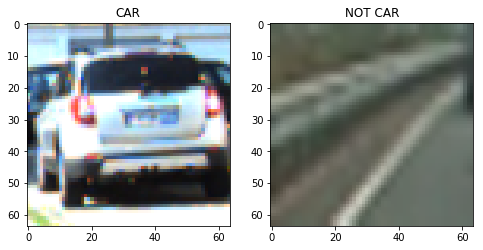

Image shape is: (64, 64, 3)


In [35]:
plt.figure(figsize=(8, 8))

car_ind = np.random.randint(0,len(car_images))
notcar_ind = np.random.randint(0,len(noncar_images))

# example car image
img_car = plt.imread("output_images/car.png")
#img_car = mpimg.imread(car_images[car_ind])   # Random image from the set

plt.subplot(121)
plt.imshow(img_car)
plt.title("CAR")

# example non-car image
img_non_car = plt.imread("output_images/notcar.png")
#img_non_car = mpimg.imread(noncar_images[notcar_ind])  # Random image from the set


plt.subplot(122)
plt.imshow(img_non_car)
plt.title("NOT CAR")

plt.show()

print("Image shape is:", img_car.shape)

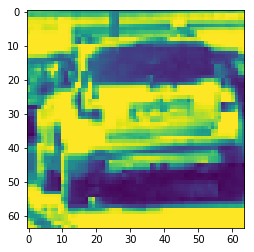

In [36]:
# Print specific channel for the image to study it
plt.imshow(img_car[:,:,2])

### Colorspace Transform Function

In [9]:
# just for a single image rather than list of images
def colorspace(img, color_space='RGB'):    
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    # Return image
    return (feature_image)

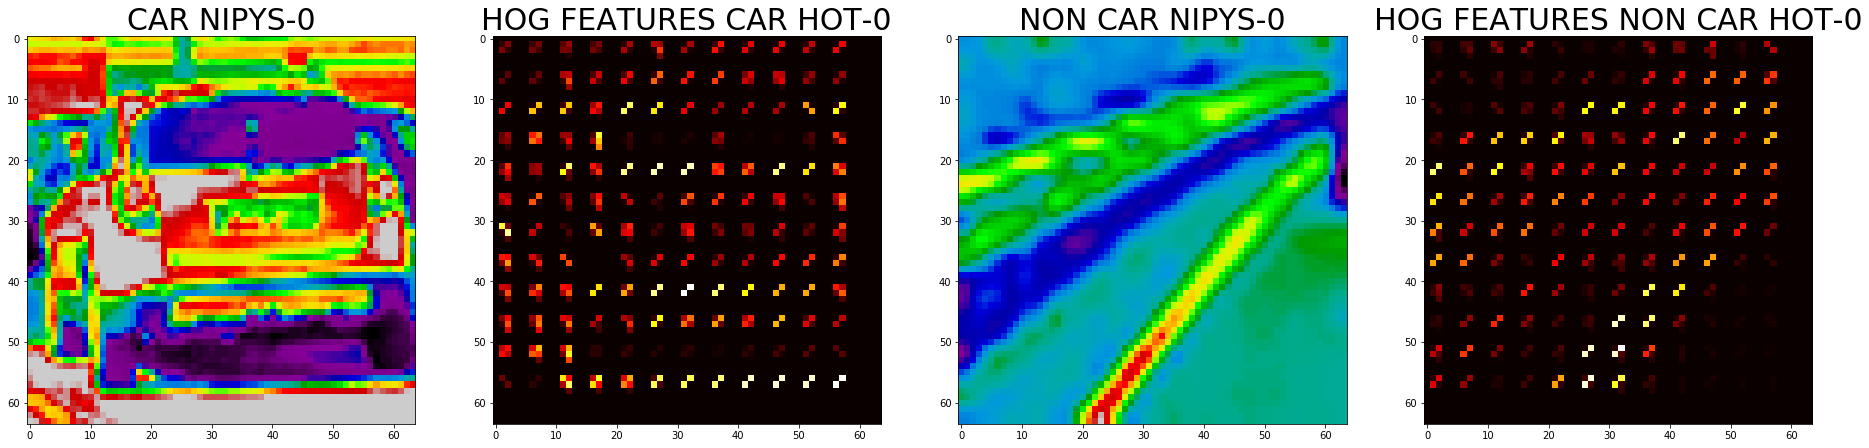

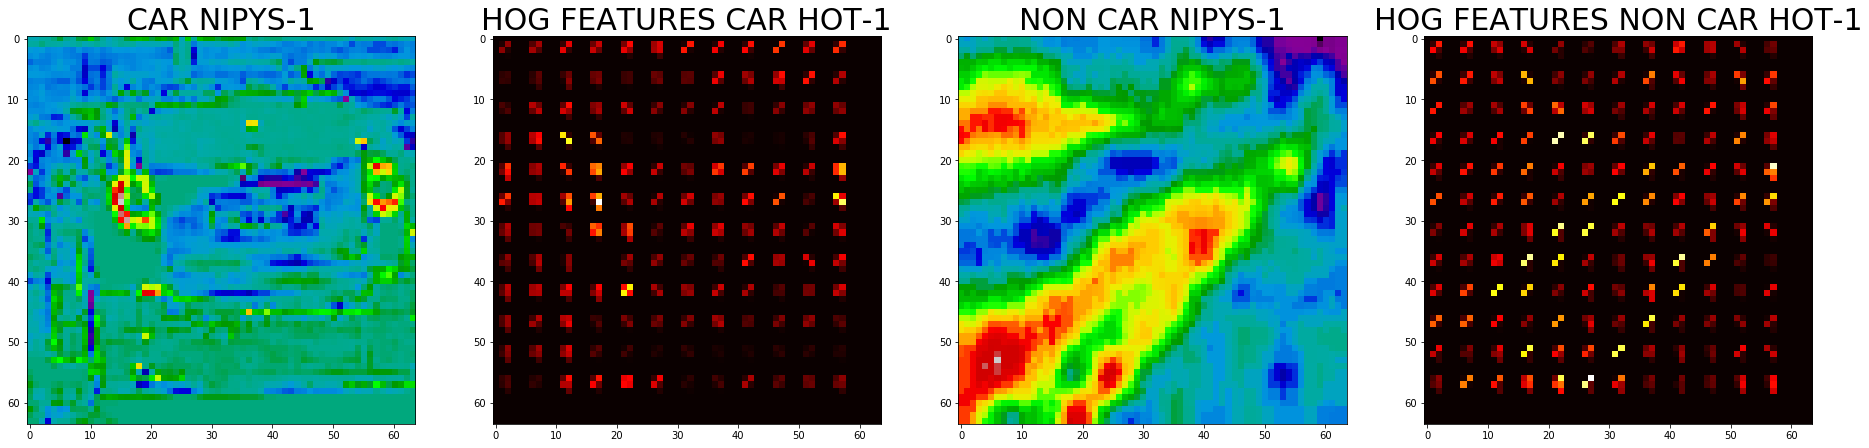

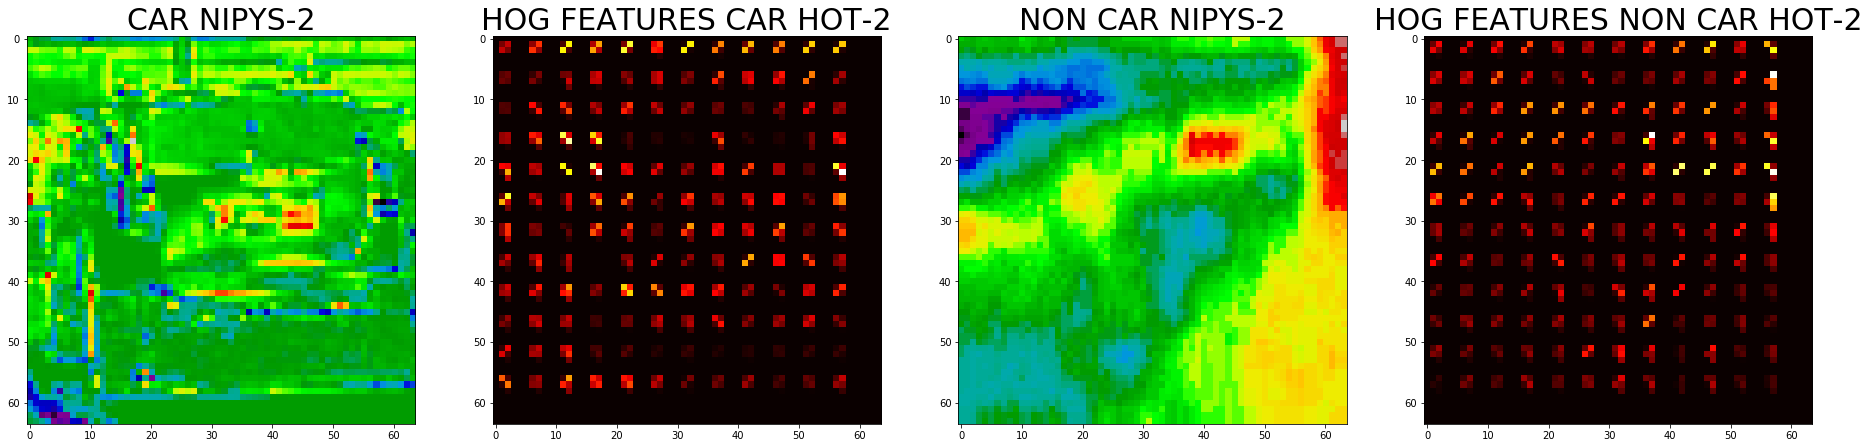

In [37]:
# Play with color space to allow for different detection sets for HOG to work on, choose the one best for the function of detecting cars
# I got YCrCb to give the best response.

colsp = 'YCrCb'  # Choose from RGB, HSV, LUV, HLS, YUV, YCrCb

### Plot HOG Image for Car and Not-Car

img_car_col = colorspace(img_car,color_space=colsp)
img_noncar_col = colorspace(img_non_car,color_space=colsp)

for ch in range(3):
    plt.figure(figsize=(32,32))
    plt.subplot(1, 4, 1)
    plt.title("CAR NIPYS-"+str(ch),fontsize=30)
    img_car_ch = img_car_col[:,:,ch]
    plt.imshow(img_car_ch, cmap="nipy_spectral")
    
    plt.subplot(1, 4, 2)
    plt.title("HOG FEATURES CAR HOT-"+str(ch),fontsize=30)
    _, img_car_ch_hog = get_hog_features(img_car_ch, 9, 5, 2, vis=True)
    plt.imshow(img_car_ch_hog, cmap="hot")
    
    plt.subplot(1, 4, 3)
    plt.title("NON CAR NIPYS-"+str(ch),fontsize=30)
    img_non_car_ch = img_noncar_col[:,:,ch]
    plt.imshow(img_non_car_ch, cmap="nipy_spectral")
    
    plt.subplot(1, 4, 4)
    plt.title("HOG FEATURES NON CAR HOT-"+str(ch),fontsize=30)
    _, img_non_car_ch_hog = get_hog_features(img_non_car_ch, 9, 5, 2, vis=True)
    plt.imshow(img_non_car_ch_hog, cmap="hot")
    
plt.show()

## TRAINING CLASSIFIER

### HYPER-PARAMETERS FOR FEATURE EXTRACTION

In [11]:
ystart = 400
ystop = 656
scales =  (1.1, 1.5, 1.8, 2.0, 2.5)
orient = 9   #9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)  # Keep this value, do not change
hist_bins = 32   # Keep this value, do not change
color_space = 'YCrCb'   # Choose from RGB, HSV, LUV, HLS, YUV, YCrCb

In [12]:
t1=time.time()

# extract car and non-car features
car_features = extract_features(car_images, 'YCrCb', orient=orient, hog_channel = 'ALL')

#car_features = extract_features(car_images, color_space, spatial_size=spatial_size, hist_bins=32, orient, pix_per_cell=8, 
                                #cell_per_block=2, hog_channel = 'ALL')
t2 = time.time()
extract_time = round(t2-t1, 4)
print(extract_time, 'Seconds to extract car features...')

t3=time.time()
noncar_features = extract_features(noncar_images, 'YCrCb', orient=orient, hog_channel = 'ALL')


t4 = time.time()
extract_time = round(t4-t3, 4)
print(extract_time, 'Seconds to extract non-car features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

C:\Users\mlgdjani\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


26.3164 Seconds to extract car features...
41.8877 Seconds to extract non-car features...


### Normalize the feature vectors

In [13]:
from sklearn.preprocessing import StandardScaler
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [14]:
# Split up data into randomized training and testing set
from sklearn.model_selection import train_test_split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state=rand_state)

print('Using:', orient,'orientations,',pix_per_cell,'pixels_per_cell,',cell_per_block,'cells per block,', 
     hist_bins,'histogram bins, and', spatial_size,'spatial sampling')
print('Feature vector shape:', (X_train.shape))

Using: 9 orientations, 8 pixels_per_cell, 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling
Feature vector shape: (11700, 8460)


In [15]:
from sklearn.svm import LinearSVC
svc = LinearSVC()

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
training_time = round(t2-t, 4)
print(training_time, 'seconds to train SVC...')

test_score = svc.score(X_test, y_test)
print('My SVC score on test images: ', test_score)
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])

24.7327 seconds to train SVC...
My SVC score on test images:  0.988376068376
My SVC predicts:  [ 1.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  0.  0.  0.  1.  1.]


## FINDING CARS BY SLIDING WINDOWS

### Define some useful functions as described in the lecture notes

In [16]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Draw_boxes function 
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='HLS', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
# Use classifier to search for the objects in the windnow
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [17]:
# function that can extract features using hog sub-sampling and make predictions
def find_cars(img,color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    ctrans_tosearch = colorspace(img_tosearch, color_space)
    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2 # 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch, and unroll the feature vectors using ravel()
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))  # Horizontally stack all the features

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch and resize it to 64x64 as our training set is 64x64 image
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))        
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox.append(((xbox_left, ytop_draw+ystart),
                             (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
    
    return bbox

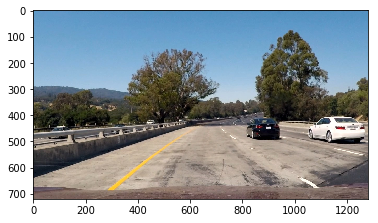

In [18]:
img = plt.imread('test_images/test1.jpg')
plt.imshow(img)

### Setting of all the hyper-parameters for feature extraction, histogram and spatial binning

In [19]:
ystart = 400
ystop = 656
scales =  scales # (1.2, 1.5, 1.8, 2.0, 2.2) is set at the beginning of the Classifier section above
orient = orient  # is set at the beginning of the Classifier section above
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)  # Keep this value, do not change
hist_bins = 32   # Keep this value, do not change
color_space = 'YCrCb'   # Choose from RGB, HSV, LUV, HLS, YUV, YCrCb

In [20]:
def find_bbox(img):
    bbox = []
    for scale in scales:
        bbox1 = find_cars(img,color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell=8, cell_per_block=2, 
                      spatial_size=spatial_size, hist_bins=hist_bins)
        bbox = bbox + bbox1
    return bbox

C:\Users\mlgdjani\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


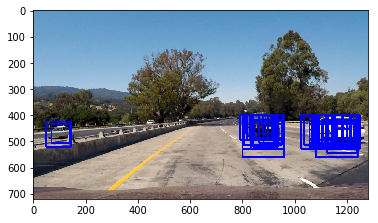

In [21]:
bbox = find_bbox(img)
for bx in bbox:
   img2=cv2.rectangle(img, bx[0], bx[1], (0,0,255), 6)
plt.imshow(img2)

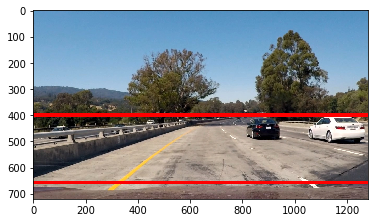

In [22]:
img = plt.imread('test_images/test1.jpg')
img = cv2.line(img, (0, ystart), (img.shape[1], ystart), (255, 0, 0), thickness=12)
img = cv2.line(img, (0, ystop), (img.shape[1], ystop), (255, 0, 0), thickness=12)
plt.imshow(img)

## HEATMAP IMPLEMENTATION

In [23]:
from scipy.ndimage.measurements import label

# hyper parameters for sliding window
ystart = 400
ystop = 656
scales = scales # (1.5, 1.8, 2.0)

In [24]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of boxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [25]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [26]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [33]:
## set threshold parameter for heat mapping
threshold = 3

In [28]:
from scipy.ndimage.measurements import label

def get_labels(img, Q = None):
    bbox = find_bbox(img)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold-1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    if Q != None:
        if len(Q) == 10:
            Q.popleft()
        Q.append(heatmap)
        sum_heat = sum(Q)
        heatmap = apply_threshold(sum_heat, threshold+2)
    labels = label(heatmap)
    return labels

C:\Users\mlgdjani\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


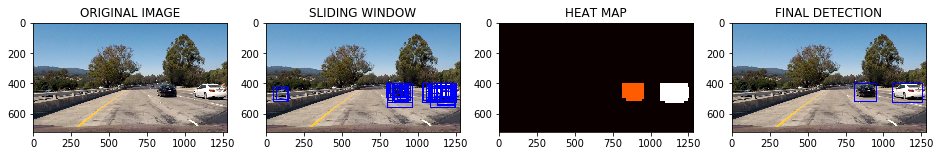

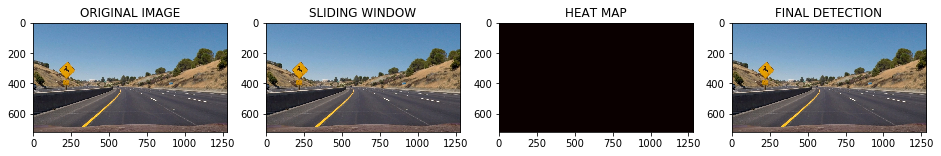

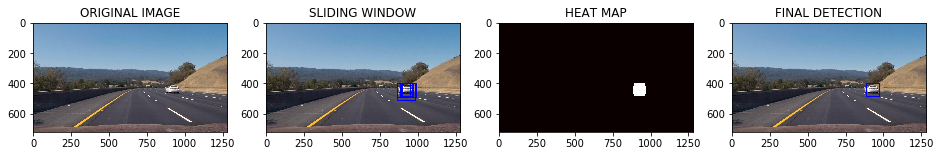

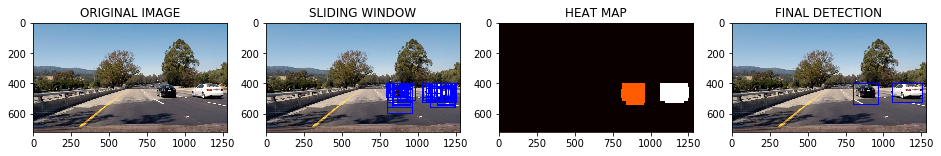

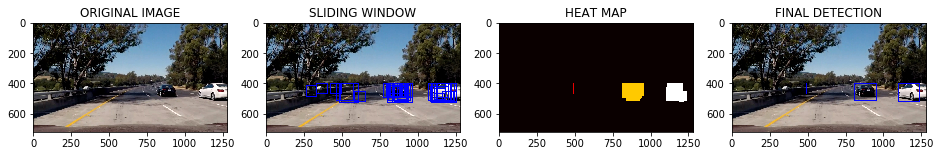

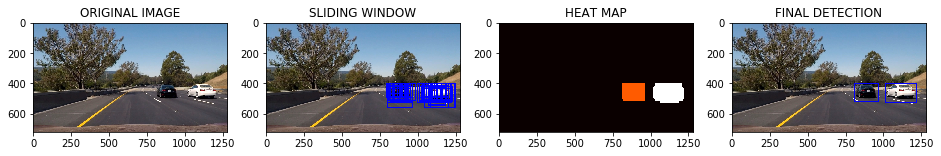

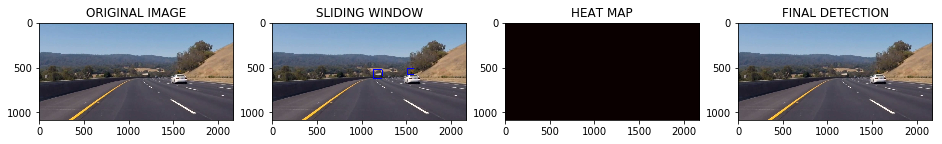

In [29]:
# read all test images
test_images = glob.glob('test_images/*.jpg')

for file in test_images:
    # print(file)
    # read image
    plt.figure(figsize=(16, 16))
    img = plt.imread(file)
    plt.subplot(1, 4, 1)
    plt.title("ORIGINAL IMAGE")
    plt.imshow(img)

    # print sliding windows output
    plt.subplot(1, 4, 2)
    img1 = np.copy(img)
    bbox = find_bbox(img1)
    for bx in bbox:
        cv2.rectangle(img1, bx[0], bx[1], (0,0,255), 6)
    plt.title("SLIDING WINDOW")
    plt.imshow(img1)

    # print heatmap
    plt.subplot(1, 4, 3)
    labels = get_labels(img)
    plt.title("HEAT MAP")
    plt.imshow(labels[0], cmap='hot')

    # print bounding box
    plt.subplot(1, 4, 4)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    plt.title("FINAL DETECTION")
    plt.imshow(draw_img)
plt.show()

## VIDEO PIPELINE

In [30]:
from collections import deque
Q = deque(maxlen=10)
def processImage(img):
    labels = get_labels(img, Q)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [34]:
# process video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#white_output = 'project_output_ycrcb_th4.mp4'
#clip1 = VideoFileClip("project_video.mp4")

white_output = 'subclip_output_ycrcb_th3_scale2_Q10.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(40,44)

white_clip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video subclip_output_ycrcb_th3_scale2_Q10.mp4
[MoviePy] Writing video subclip_output_ycrcb_th3_scale2_Q10.mp4


 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [03:14<00:01,  1.92s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip_output_ycrcb_th3_scale2_Q10.mp4 

Wall time: 3min 15s
